In [10]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch

import numpy as np
import matplotlib.pyplot as plt

from datasets import ring_dataset, randomized_ring_dataset, energy_randomized_ring_dataset
from models import DGBaNR, big_DGBaNR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset:

In [13]:
data_gen = energy_randomized_ring_dataset(N=32)
features, imgs = data_gen.generate_dataset(data_size=64000, seed=42, device='cpu', test_return=True)

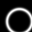

In [14]:
gaussian_ring, center, mean, sig = data_gen.gaussian_ring(1)
gaussian_ring, center, mean, sig = gaussian_ring[0], center[0], mean[0], sig[0]

features = torch.Tensor([[center[0], center[1], mean, sig, gaussian_ring.mean() * 32 * 32]])

Image.fromarray((gaussian_ring.reshape((32, 32)) * 255).astype(np.uint8))

Test generator:

In [65]:
# load generator
generator = big_DGBaNR(data_gen.n_features, 32, 'sigmoid')
generator.load_state_dict(torch.load('../save_model/big_DGBaNR_sigmoid_energy_random_1280000_32_Adam_mse_loss_5.pt', map_location=torch.device('cpu')))
generator.eval()

big_DGBaNR(
  (linear1): LinearReparameterization()
  (linear2): LinearReparameterization()
  (conv1): ConvTranspose2dReparameterization()
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2dReparameterization()
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2dReparameterization()
)

In [66]:
sum(p.numel() for p in generator.parameters())

9461762

In [67]:
# setting the base feature
n_samples = 3000
feature = data_gen.scaler.transform(np.array([[15, 15, 9.4, 3.6]]))
features = [torch.Tensor(feature) for i in range(n_samples)]

# getting the predictions for this feature
pred_rings = np.zeros((n_samples, 32, 32))
with torch.no_grad():
    for i, tensor in enumerate(features):
        pred_rings[i] += generator(tensor)[0].numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(15, 15, 9.4, 3.6) * 255

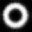

In [68]:
# predicted gaussian ring
Image.fromarray(pred_prob.astype(np.uint8))

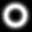

In [69]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

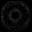

In [70]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [71]:
# relative error
print(np.abs(true_prob - pred_prob).mean() / true_prob.mean())

0.1034826997667873


[0.63747895 0.64747895 0.65747895 0.66747895 0.67747895 0.68747895
 0.69747895 0.70747895 0.71747895 0.72747895 0.73747895 0.74747895
 0.75747895 0.76747895 0.77747895 0.78747895 0.79747895 0.80747895
 0.81747895 0.82747895 0.83747895 0.84747895 0.85747895 0.86747895
 0.87747895 0.88747895 0.89747895 0.90747895 0.91747895 0.92747895
 0.93747895 0.94747895 0.95747895 0.96747895 0.97747895 0.98747895
 0.99747895 1.00747895 1.01747895 1.02747895 1.03747895 1.04747895
 1.05747895 1.06747895 1.07747895 1.08747895 1.09747895 1.10747895
 1.11747895 1.12747895 1.13747895 1.14747895 1.15747895 1.16747895
 1.17747895 1.18747895 1.19747895 1.20747895 1.21747895 1.22747895]


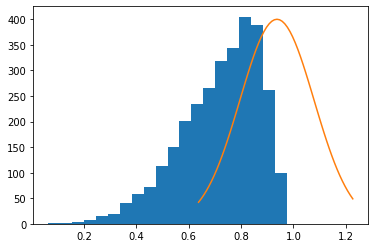

In [82]:
# getting the distribution for one pmt
pmt = (9, 9)
pred_pmt_distr = pred_rings[:, 9, 9]
plt.hist(pred_pmt_distr, bins=20)

val = np.arange(-0.3, 0.3, 0.01) + true_prob[pmt] / 255
print(val)
true_pmt_distr = np.exp(-(val - true_prob[pmt] / 255)**2 / 0.2**2) * 400
plt.plot(val, true_pmt_distr)
plt.show()